<a href="https://colab.research.google.com/github/Mohamed2bdelaziz/NLP/blob/main/CNN_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> [<= Source =>](https://keras.io/examples/nlp/pretrained_word_embeddings/#load-pretrained-word-embeddings)


In [30]:
import nltk
nltk.download('wordnet')
nltk.download(["stopwords"])
from nltk.corpus import stopwords
import re
from nltk import WordNetLemmatizer
lemma =WordNetLemmatizer()
stopwords = set(stopwords.words("english"))


import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm
import keras
from sklearn.model_selection import train_test_split
import tensorflow
from keras.layers import Embedding
from tensorflow.keras.metrics import F1Score
from sklearn.metrics import confusion_matrix

from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout
from keras.callbacks import EarlyStopping


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# download the dataset, then unzipping it
!kaggle datasets download -d kazanova/sentiment140
!unzip /content/sentiment140.zip

 89% 72.0M/80.9M [00:00<00:00, 185MB/s]
100% 80.9M/80.9M [00:00<00:00, 183MB/s]
Archive:  /content/sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [3]:
# download the pretrained glove models embeddings
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

!unzip -q glove.6B.zip

--2024-04-29 00:22:47--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 38s  

2024-04-29 00:25:26 (5.19 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [6]:
import pandas as pd

cols = ["target","ids","date","flag","user","text"]
data_df = pd.read_csv(
    "/content/training.1600000.processed.noemoticon.csv",
    names= cols,
    encoding='latin-1')

data_df.shape

(1600000, 6)

In [7]:
# replacing target 4 with 1 in data
data_df.target = data_df.target.replace({4:1})


In [8]:
data_df.target.unique()

array([0, 1])

In [9]:
X = data_df['text'].values
Y = data_df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)


In [10]:
X_train.shape, y_test.shape

((1280000,), (320000,))

In [11]:
vectorizer = keras.layers.TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tensorflow.data.Dataset.from_tensor_slices(X_train).batch(64)
vectorizer.adapt(text_ds)

In [12]:
next(iter(text_ds))

<tf.Tensor: shape=(64,), dtype=string, numpy=
array([b"@jbtaylor WIth ya. &quot;I'd like a Palm Pre, Touchstone charger. ReadyNow? Yes, that sounds good. But is my beer ready now?'  #prelaunch",
       b'felt the earthquake this afternoon, it seems to be a , but  at the epicenter ',
       b'Ruffles on shirts are like so in, me Likey ',
       b'Pretty bad night into a crappy morning....FML! If only buttface didnt say he could go into work today ',
       b'@dcbriccetti yeah, what a clear view! ',
       b'One more time Follow my fam #FF @georgeann13 @nakithebeatman @flimackgod @chaz81 @djt_elle @jaejaedynomite welcome to Friday Follow me 2 ',
       b'@MsJBell U rock!!! Thanks.  Will be added to next RobCrotch (tm) video. ',
       b"@ssnider yes please! met your fiancee at ian's party the other day, btw... she's very sweet  congrats to you guys!",
       b"My gawd! They've finished the whole bowl before I even posted my previous tweet! Making 2nd bowl ",
       b"@marty_k awesome gam

In [13]:
len(vectorizer.get_vocabulary()), *vectorizer.get_vocabulary()[500:515]

(20000,
 '6',
 'office',
 'boo',
 'dog',
 'course',
 'btw',
 'seeing',
 'started',
 'heart',
 'kind',
 'internet',
 'hehe',
 'using',
 'part',
 'mind')

In [14]:
test_sent = "I love the natural language processing course".lower()
output = vectorizer([[test_sent]])
output.numpy()

array([[   2,   46,    4, 3283, 2538, 7996,  504,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [15]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

[word_index[w] for w in test_sent.split()]

[2, 46, 4, 3283, 2538, 7996, 504]

In [16]:
X_train = vectorizer(np.array([[s] for s in X_train])).numpy().astype(np.float64)
X_test = vectorizer(np.array([[s] for s in X_test])).numpy().astype(np.float64)

y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)


In [17]:
X_train.shape, X_train.dtype, y_test.shape, y_test.dtype,

((1280000, 200), dtype('float64'), (320000,), dtype('float32'))

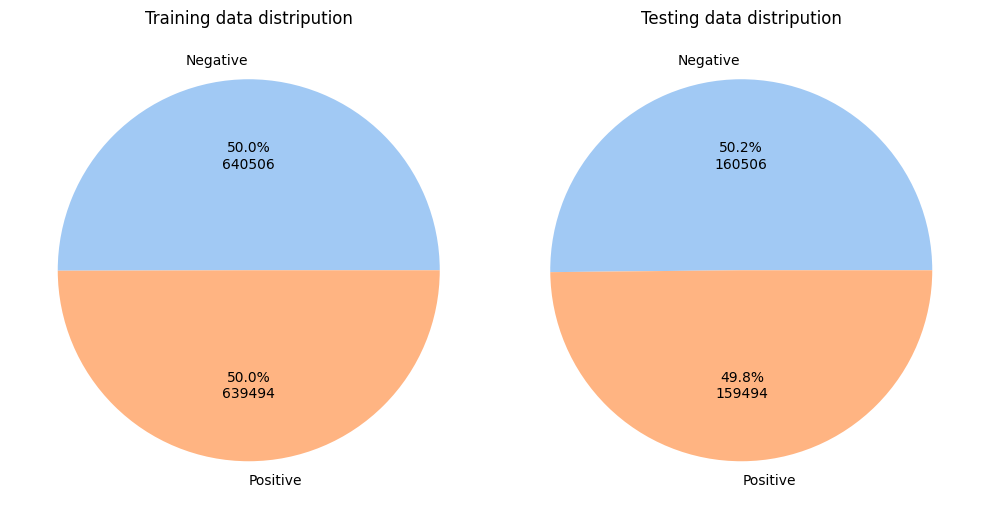

In [18]:
labels = ['Negative', 'Positive']
colors = sns.color_palette("pastel")

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.pie(
    pd.DataFrame(y_train).value_counts(),
    labels=labels,
    colors=colors,
    autopct=lambda x: '{:.1f}%\n{:.0f}'.format(x, len(y_train)*x/100)
)
plt.title('Training data distripution')

plt.subplot(1, 2, 2)
plt.pie(
    pd.DataFrame(y_test).value_counts(),
    labels=labels,
    colors=colors,
    autopct=lambda x: '{:.1f}%\n{:.0f}'.format(x, len(y_test)*x/100)
)
plt.title('Testing data distripution')

plt.tight_layout()
plt.show()

# print(':\n')
# plt.pie(y_train)
# # pd.DataFrame(y_train).plot(kind='pie', subplots=True)
# print('Testing data distripution:\n',pd.DataFrame(y_test).value_counts())

In [19]:
# !gdown 0B7XkCwpI5KDYNlNUTTlSS21pQmM


In [20]:
path_to_glove_file = "glove.6B.300d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


Found 400000 word vectors.


In [21]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 16302 words (3698 misses)


In [43]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=False,
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

## Arch#1
int_sequences_input = keras.Input(shape=(None,), dtype="int32")
embedded_sequences = embedding_layer(int_sequences_input)
x = keras.layers.Dropout(0.5)(embedded_sequences) # 0.4
x = keras.layers.Conv1D(128, 5, activation="relu")(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Conv1D(128, 5, activation="relu")(x)
x = keras.layers.MaxPooling1D(5)(x)
x = keras.layers.Conv1D(128, 5, activation="relu")(x)
x = keras.layers.GlobalMaxPooling1D()(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
preds = keras.layers.Dense(data_df.target.nunique()-1, activation="sigmoid")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

## Arch#2
# vocab_size = 1000
# maxlen = 1000
# batch_size = 128
# embedding_dims = 300
# filters = 16
# kernel_size = 3
# hidden_dims = 250
# epochs = 30

# model = keras.models.Sequential()
# model.add(keras.Input(shape=(None,), dtype="int32"))
# model.add(embedding_layer)
# model.add(Dropout (0.5))
# # model.add(Conv1D (filters, padding='valid',kernel_size,activation= 'relu'))
# model.add(Conv1D(filters, kernel_size, activation='relu', padding='valid'))
# model.add(MaxPooling1D())
# # model.add(Conv1D (filters,padding='valid',kernel_size,activation='relu'))
# model.add(Conv1D(filters, kernel_size, activation='relu', padding='valid'))
# # model.add(MaxPooling1D())
# model.add(keras.layers.GlobalMaxPooling1D())

# model.add(Dense (250, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense (1, activation='sigmoid'))
# model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_8 (Embedding)     (None, None, 300)         6000600   
                                                                 
 dropout_8 (Dropout)         (None, None, 300)         0         
                                                                 
 conv1d_12 (Conv1D)          (None, None, 128)         192128    
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, None, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, None, 128)         82048     
                                                           

In [44]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop", # adam
    metrics=["acc", F1Score()]
)

In [45]:
history = model.fit(
    X_train,
    y_train,
    batch_size=128, #64
    epochs=32, #16
    validation_split=0.2,
    callbacks=[early_stopping]
)


Epoch 1/32
8000/8000 [==============================] - 105s 13ms/step - loss: 0.5006 - acc: 0.7547 - f1_score: 0.6662 - val_loss: 0.4435 - val_acc: 0.7930 - val_f1_score: 0.6666
Epoch 2/32
8000/8000 [==============================] - 103s 13ms/step - loss: 0.4642 - acc: 0.7805 - f1_score: 0.6662 - val_loss: 0.4353 - val_acc: 0.7979 - val_f1_score: 0.6666
Epoch 3/32
8000/8000 [==============================] - 102s 13ms/step - loss: 0.4541 - acc: 0.7870 - f1_score: 0.6663 - val_loss: 0.4249 - val_acc: 0.8025 - val_f1_score: 0.6666
Epoch 4/32
8000/8000 [==============================] - 100s 13ms/step - loss: 0.4509 - acc: 0.7901 - f1_score: 0.6664 - val_loss: 0.4353 - val_acc: 0.7991 - val_f1_score: 0.6666
Epoch 5/32
8000/8000 [==============================] - 115s 14ms/step - loss: 0.4479 - acc: 0.7918 - f1_score: 0.6665 - val_loss: 0.4253 - val_acc: 0.8061 - val_f1_score: 0.6668
Epoch 6/32
8000/8000 [==============================] - 106s 13ms/step - loss: 0.4457 - acc: 0.7937 - f1_

In [46]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 48s 5ms/step - loss: 0.4123 - acc: 0.8131 - f1_score: 0.6683


[0.4122764766216278, 0.8130687475204468, array([0.668278], dtype=float32)]

In [47]:
y_pred = model.predict(X_test)

10000/10000 [==============================] - 30s 3ms/step


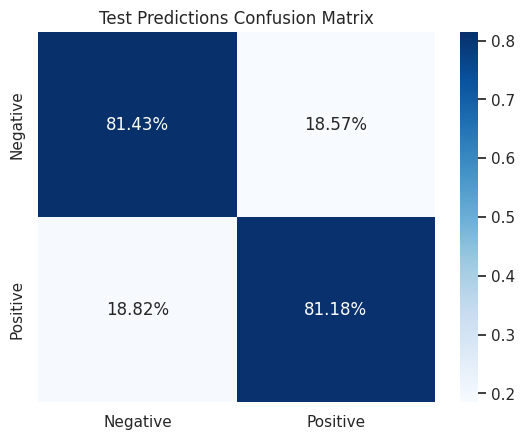

In [48]:
y_pred_ = np.where(y_pred > 0.5 , 1, 0)

conf_mat = confusion_matrix(y_test, y_pred_)
conf_mat = conf_mat.astype(np.float64) / np.sum(conf_mat, axis=1)[:, np.newaxis]

sns.heatmap(
    conf_mat,
    annot=True,
    fmt='.2%',
    xticklabels = labels,
    yticklabels = labels,
    cmap='Blues')
plt.title('Test Predictions Confusion Matrix')
plt.show()

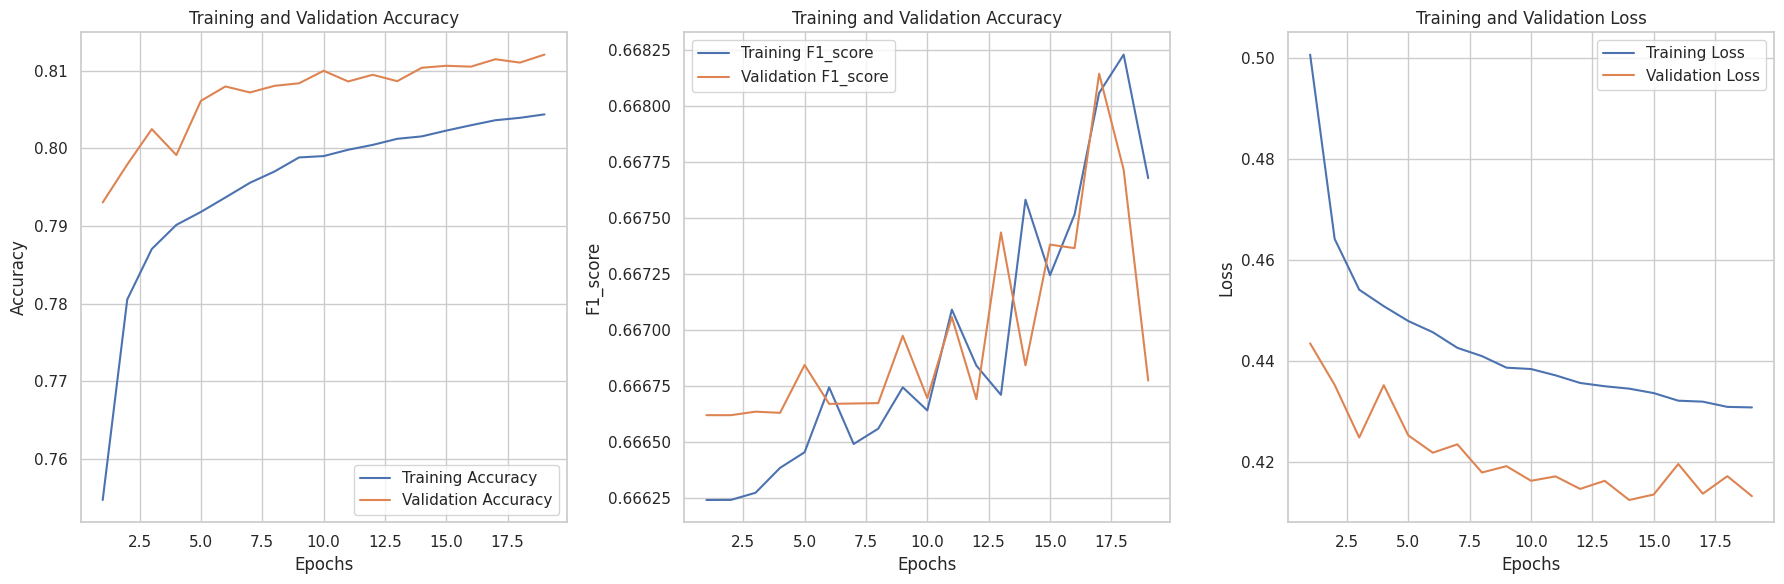

In [50]:
acc = history.history['acc']
val_acc = history.history['val_acc']
f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']
loss = history.history['loss']
val_loss = history.history['val_loss']


# Set up the figure
plt.figure(figsize=(18, 6))

# Plot training and validation accuracy
plt.subplot(1, 3, 1)
plt.plot(range(1, len(acc) + 1), acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation f1_score
plt.subplot(1, 3, 2)
plt.plot(range(1, len(f1) + 1), f1, label='Training F1_score')
plt.plot(range(1, len(val_f1) + 1), val_f1, label='Validation F1_score')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('F1_score')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 3, 3)
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Customize the style using Seaborn
sns.set(style='whitegrid')  # You can choose other styles as well

# Show the plots
plt.grid(True)
plt.tight_layout()
plt.show()


In [52]:
# model.save("text_classifier_cnn_model.h5")